In [4]:
!pip install comet_ml

In [9]:
import clip
import numpy as np
import torch
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image

from combiner import Combiner

device = "cuda" if torch.cuda.is_available() else "cpu"
combiner = Combiner(640, 2560, 5120).to(device)
saved_state_dict = torch.load("C:/Users/HIEN/CLIP4Cir/CIRR/RN50x4_fullft/cirr_comb_RN50x4_fullft.pt", map_location=device)
combiner.load_state_dict(saved_state_dict["Combiner"], strict=False)
combiner.eval()
combining_function = combiner.combine_features

clip_model, preprocess = clip.load("RN50x4", device=device)
print(device)

cpu


In [25]:
import os 

# Encode image dataset
path_folder = "D:/AIC_EITA/archive/Test"

def learning_data(path_image_folder, model, preprocess):
    image_paths = os.listdir(path_folder)
    image_features_list = []

    for image_path_in_folder in image_paths:
        image_path = os.path.join(path_image_folder, image_path_in_folder)
        image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
        with torch.no_grad():
            image_features = clip_model.encode_image(image)
            image_features_list.append((image_path_in_folder, image_features))
    return image_features_list

image_features_list = learning_data(path_folder, clip_model, preprocess)
torch.save(image_features_list,"D:/AIC_EITA/archive/pretrained.pt")


Query: people
Hinh anh thu 1: Similarity Score: 0.4396587014198303	 Path: D:/AIC_EITA/archive/Test\58368365_03ed3e5bdf.jpg


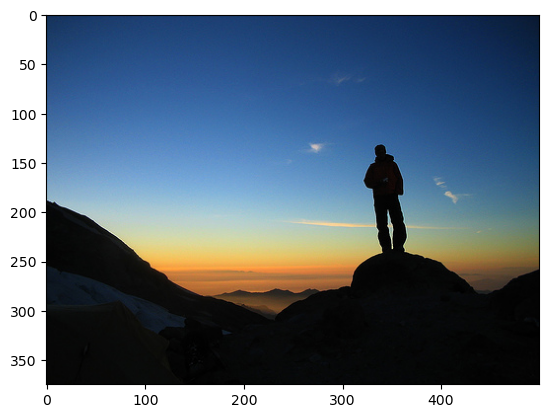

Hinh anh thu 2: Similarity Score: 0.4222392141819	 Path: D:/AIC_EITA/archive/Test\55473406_1d2271c1f2.jpg


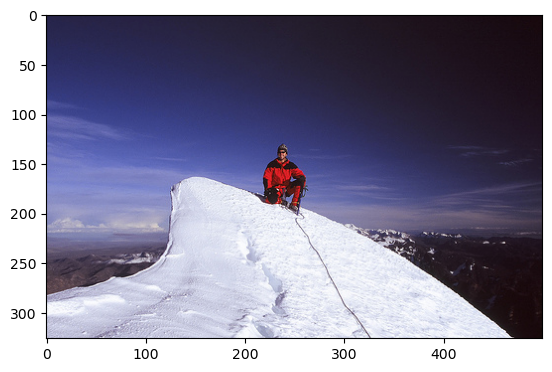

Hinh anh thu 3: Similarity Score: 0.4176773726940155	 Path: D:/AIC_EITA/archive/Test\56494233_1824005879.jpg


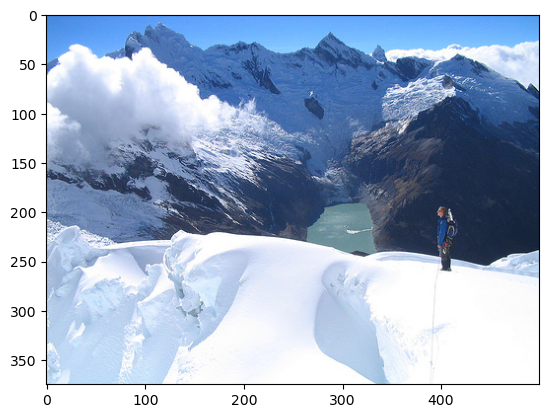

Hinh anh thu 4: Similarity Score: 0.4137811064720154	 Path: D:/AIC_EITA/archive/Test\54723805_bcf7af3f16.jpg


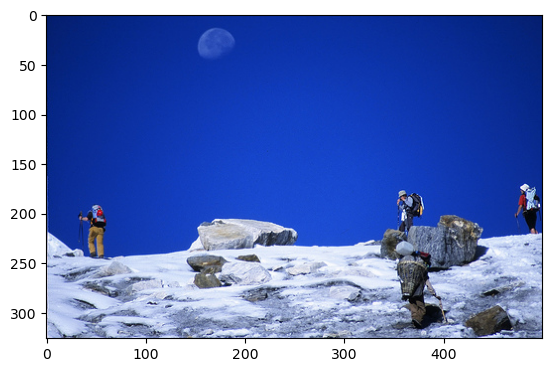

Hinh anh thu 5: Similarity Score: 0.4111265540122986	 Path: D:/AIC_EITA/archive/Test\58363930_0544844edd.jpg


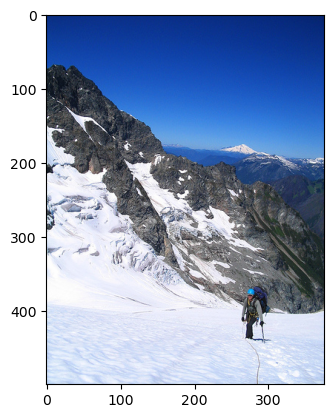

In [33]:
import PIL.Image as Image
import matplotlib.pyplot as plt

# Load data
base_image_path = "D:/AIC_EITA/archive/Test"

image = "C:/Users/HIEN/CLIP4Cir/mountain.jpg"
text = "people"

# Tokenize
text_inputs = clip.tokenize(text, context_length=77).to(device)

# Encode the text+image query
with torch.no_grad():
    text_features = clip_model.encode_text(text_inputs)
    image = preprocess(Image.open(image)).unsqueeze(0).to(device)
    reference_image_features = clip_model.encode_image(image)
    batch_predicted_features = combining_function(reference_image_features.reshape(1,640), text_features)

# Save embeddings in combine_features
combine_features = torch.empty((0, clip_model.visual.output_dim)).to(device, non_blocking=True)
combine_features = torch.vstack((combine_features, F.normalize(batch_predicted_features, dim=-1)))

# Calculate cosine similarity between query and each of image in dataset
img_feature_list = torch.load("D:/AIC_EITA/archive/pretrained.pt")
similarities = []
for img_path, img_features in img_feature_list:
    img_features = F.normalize(img_features, dim=-1)  # Normalize the image features
    similarity = torch.nn.functional.cosine_similarity(img_features, combine_features, dim=1).item()
    full_img_path = os.path.join(base_image_path, img_path)
    similarities.append((full_img_path, similarity))

# Sort similarities in descending order (most similar first)
similarities.sort(key=lambda x: x[1], reverse=True)

# Retrieve top 5 most similar images
top_5_similar_images = similarities[:5]

# Find topK
print(f"Query: {text}")
for idx, (img_path, similarity) in enumerate(top_5_similar_images, start=1):
    print(f"Hinh anh thu {idx}: Similarity Score: {similarity}\t Path: {img_path}")
    im = plt.imread(img_path)
    plt.imshow(im)
    plt.show()
